# The effect of volatility on a 60/40 portfolio

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(pracma)
library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)
library(ggpubr)

options(repr.plot.width=16, repr.plot.height=8)
options(tibble.width = Inf)

indices <- Indices()

In [2]:
startDate <- as.Date('1999-01-01')
endDate <- as.Date('2019-12-15')

eqIndex1 <- "NIFTY 50 TR" 

lookback <- 5*12 #months

In [4]:
eqDt1 <- indices$NseTimeSeries() %>%
    filter(NAME == eqIndex1 & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

eqXts1 <- Common.NormalizeMonthlyDates(monthlyReturn(xts(eqDt1$CLOSE, eqDt1$TIME_STAMP)))
eqXts1 <- eqXts1[-1]
eqXts1 <- eqXts1[-nrow(eqXts1)]

In [5]:
meanSdEq <- rollapply(eqXts1, lookback, function(X){
    monthlyAvg <- as.numeric(mean(coredata(X)))
    monthlySd <- as.numeric(sd(coredata(X)))
    
    xts(matrix(c(monthlyAvg, monthlySd), nrow=1), index(last(X)))
}, by.column=F)

meanSdEq <- 100*na.omit(meanSdEq)
names(meanSdEq) <- c('AVG', 'SD')

In [6]:
plotLineTimeSeries <- function(seriesXts, mainTitle){
    toPlot <- data.frame(seriesXts)
    colnames(toPlot) <- names(seriesXts)
    ycolName <- toString(names(seriesXts)[1])
    toPlot$T <- as.Date(index(seriesXts))
    
    startDate <- index(first(seriesXts))
    endDate <- index(last(seriesXts))

    xAxisTicks <- seq(from=startDate, to=endDate, length.out=10)
    
    ggplot(toPlot, aes_(x=as.name('T'), y=as.name(ycolName))) +
        theme_economist() +
        theme(axis.text.x=element_text(angle=90, hjust=1)) +
        geom_line() +
        scale_x_date(breaks=xAxisTicks, date_labels="%Y-%b") +
        labs(x='', y='', fill='', title=mainTitle, subtitle=sprintf("%d-month lookback [%s:%s]", lookback, startDate, endDate)) +
        annotate("text", x=endDate, y=as.numeric(min(seriesXts)), 
                 label = "@StockViz", hjust=1.1, vjust=-1.1, 
                 col="white", cex=6, fontface = "bold", alpha = 0.8)
}

## Plot the rolling average monthly returns

     Index                 AVG        
 Min.   :2004-06-20   Min.   :0.3695  
 1st Qu.:2008-04-27   1st Qu.:0.9769  
 Median :2012-03-05   Median :1.1837  
 Mean   :2012-03-05   Mean   :1.4519  
 3rd Qu.:2016-01-12   3rd Qu.:1.9104  
 Max.   :2019-11-20   Max.   :3.4757  


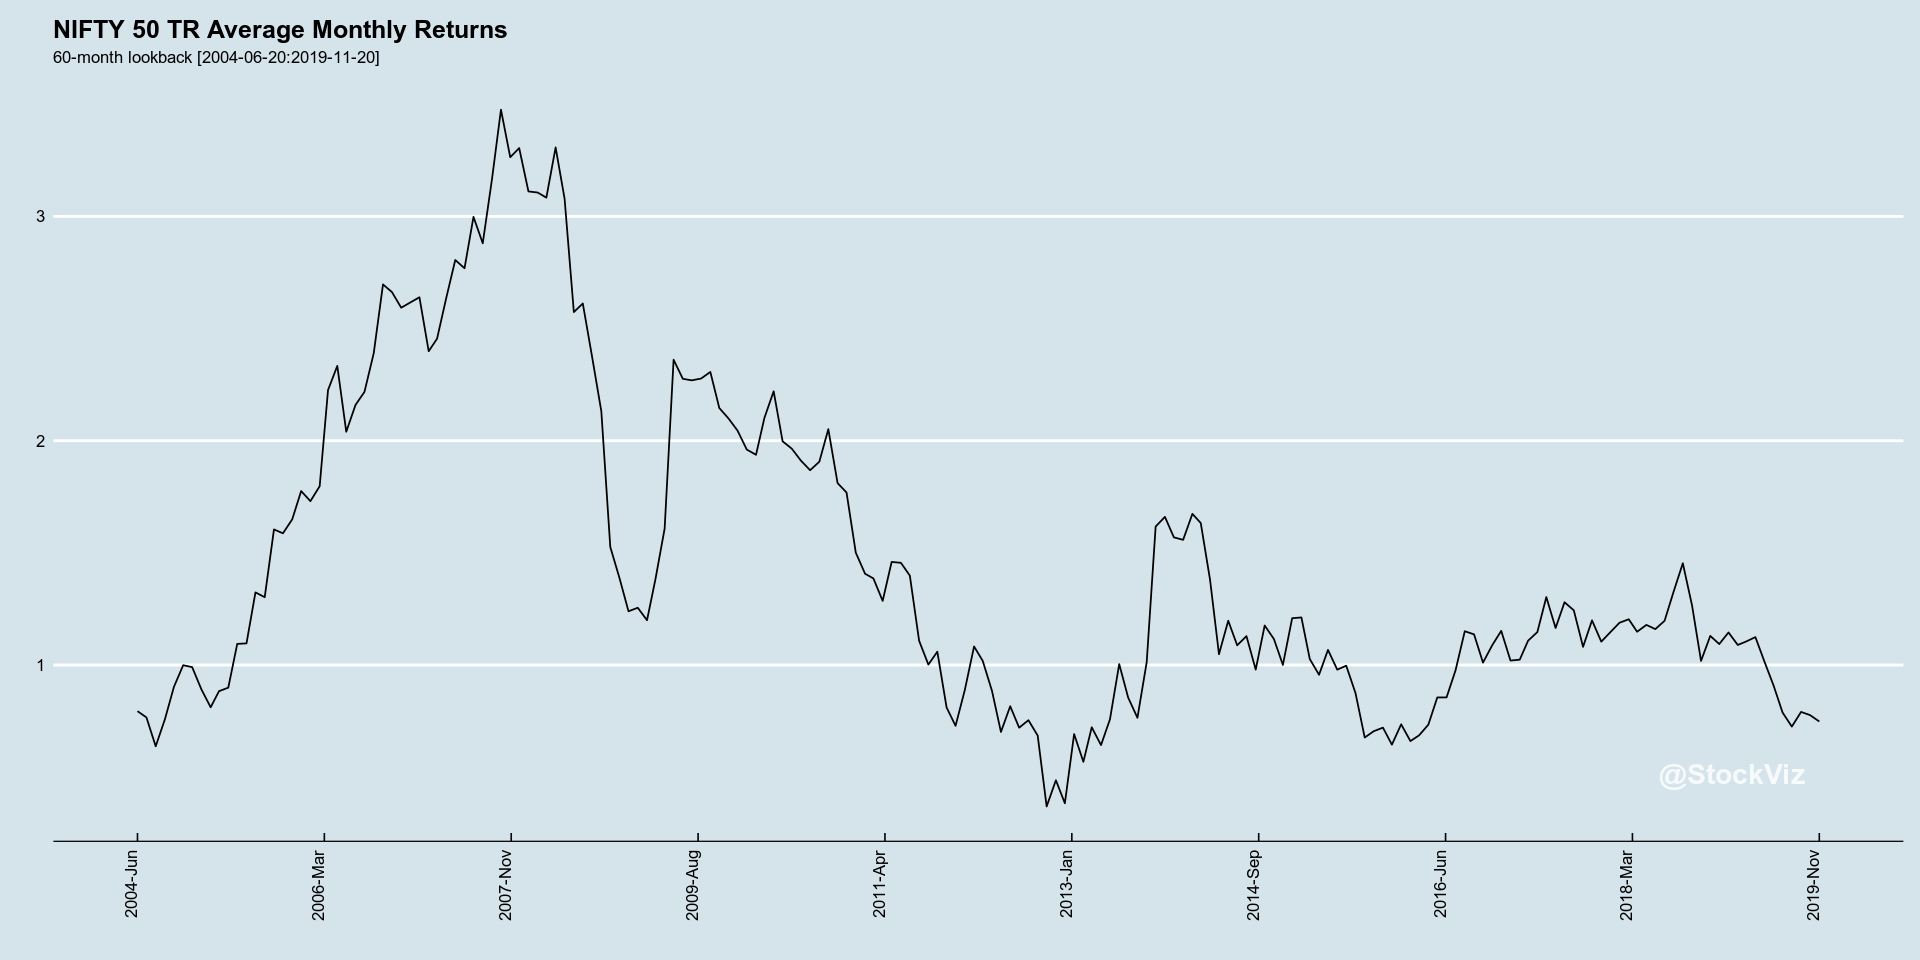

In [7]:
plotLineTimeSeries(meanSdEq[,1], sprintf("%s Average Monthly Returns", eqIndex1))
print(summary(meanSdEq[,1]))

## Plot rolling standard deviation of monthly returns

     Index                  SD       
 Min.   :2004-06-20   Min.   :3.812  
 1st Qu.:2008-04-27   1st Qu.:4.835  
 Median :2012-03-05   Median :7.026  
 Mean   :2012-03-05   Mean   :6.576  
 3rd Qu.:2016-01-12   3rd Qu.:8.366  
 Max.   :2019-11-20   Max.   :8.928  


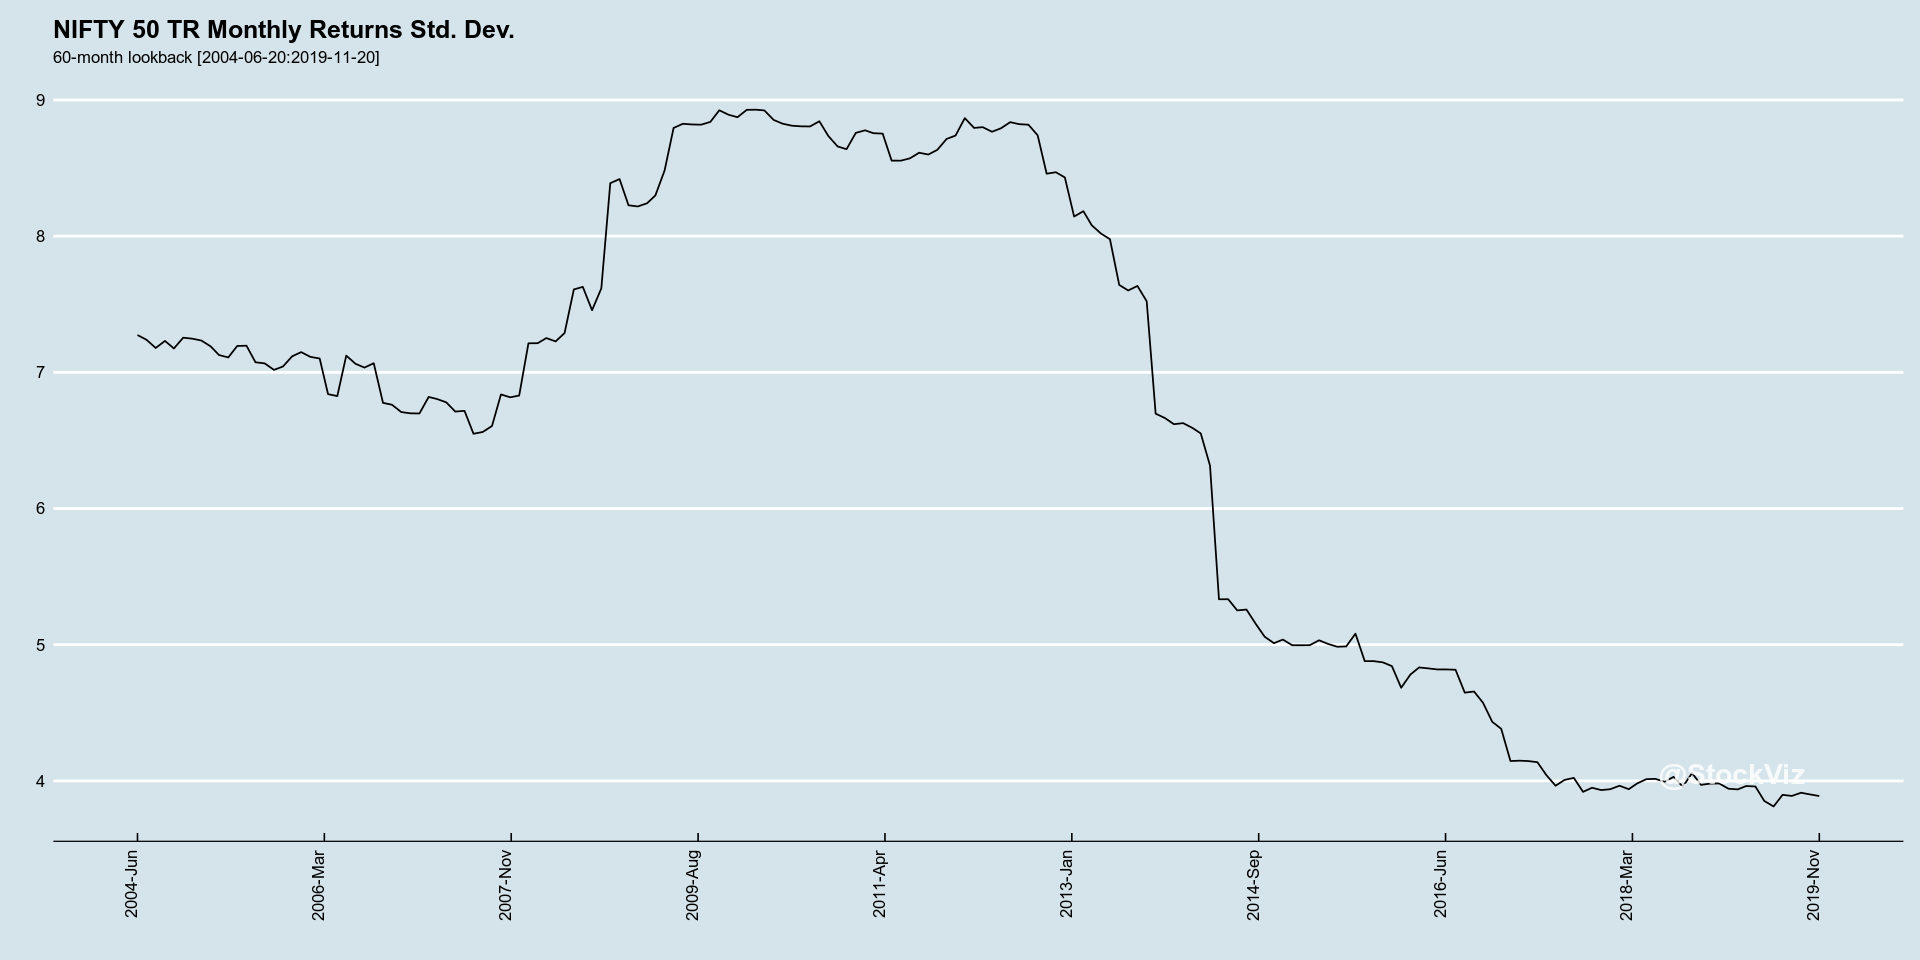

In [8]:
plotLineTimeSeries(meanSdEq[,2], sprintf("%s Monthly Returns Std. Dev.", eqIndex1))
print(summary(meanSdEq[,2]))

It looks like monthly returns have become a lot less volatile through time.

Based on the intuition from the above charts, setup the std-dev and avg ranges for the simulation.

This assumes that monthly returns are normally distributed but that is obviously wrong. But it is enough for our what we are trying to visualize.

In [9]:
sdVals <- c(0.035, 0.04, 0.045, 0.05)
avgVals <- c(0.009, 0.01, 0.011, 0.012, 0.013, 0.014)
numMonths <- 20*12 #20 years
numIters <- 10000

dateSeq <- seq(from=as.Date("2000-01-20"), by="month", length.out=numMonths)
monthlyBndRet <- 0.05/12 #assume annual bond returns are between 5-6%
bndXts <- xts(rep(monthlyBndRet, numMonths), dateSeq)

In [10]:
simRets <- data.frame(I=-1.0, J=-1.0, RET_EQ=-99.99, RET_60=-99.99)
for(i in 1:length(sdVals)){
    for(j in 1:length(avgVals)){
        for(numIter in 1:numIters){
            rndMonthlyRet <- rnorm(numMonths, mean=avgVals[j], sd=sdVals[i])
            retXts <- xts(rndMonthlyRet, dateSeq)
            ret60Xts <- 0.6*retXts + 0.4*bndXts

            annRet <- as.numeric(Return.annualized(retXts))
            ann60Ret <- as.numeric(Return.annualized(ret60Xts))
            simRets <- rbind(simRets, c(i, j, 100.0*annRet, 100.0*ann60Ret))
        }
    }
}
simRets <- simRets[-1,]

In [11]:
jReal<-5 #fix this to get a read on the summary stats of effect of std-dev on final return distribution
for(i in 1:length(sdVals)){
    print(sprintf("********* sd = %.4f; avg = %.4f **********", sdVals[i], avgVals[jReal]))
    print(summary(simRets[simRets$I==i & simRets$J==jReal, ]$RET_EQ))
    print("----------------------------------------------------")
    print(summary(simRets[simRets$I==i & simRets$J==jReal,]$RET_60))
}

[1] "********* sd = 0.0350; avg = 0.0130 **********"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.651  13.902  15.970  16.000  18.049  29.674 
[1] "----------------------------------------------------"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.406  10.501  11.703  11.711  12.904  19.492 
[1] "********* sd = 0.0400; avg = 0.0130 **********"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.348  13.260  15.691  15.706  18.090  29.765 
[1] "----------------------------------------------------"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.662  10.190  11.596  11.596  12.986  19.575 
[1] "********* sd = 0.0450; avg = 0.0130 **********"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.525  12.773  15.396  15.461  18.127  32.653 
[1] "----------------------------------------------------"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.289   9.960  11.496  11.517  13.072  21.246 
[1] "********* sd = 0.0500; avg = 0.0130 **********"
   Min. 1st Qu.  Median

In [12]:
summMeans <- simRets %>%
                filter(J == jReal) %>%
                group_by(I) %>%
                summarize(RET_EQ = median(RET_EQ), RET_60 = median(RET_60)) %>%
                select(I, RET_EQ, RET_60) %>%
                mutate(X='MEDIAN') %>%
                as.data.frame()

summMin <- simRets %>%
                filter(J == jReal) %>%
                group_by(I) %>%
                summarize(RET_EQ = min(RET_EQ), RET_60 = min(RET_60)) %>%
                select(I, RET_EQ, RET_60) %>%
                mutate(X='MIN') %>%
                as.data.frame()

summSdP <- simRets %>%
                filter(J == jReal) %>%
                group_by(I) %>%
                summarize(RET_EQ = mean(RET_EQ) + sd(RET_EQ), RET_60 = mean(RET_60) + sd(RET_60)) %>%
                select(I, RET_EQ, RET_60) %>%
                mutate(X='SDP') %>%
                as.data.frame()

summSdM <- simRets %>%
                filter(J == jReal) %>%
                group_by(I) %>%
                summarize(RET_EQ = mean(RET_EQ) - sd(RET_EQ), RET_60 = mean(RET_60) - sd(RET_60)) %>%
                select(I, RET_EQ, RET_60) %>%
                mutate(X='SDM') %>%
                as.data.frame()

summs <- rbind(summMeans, summMin, summSdP, summSdM)

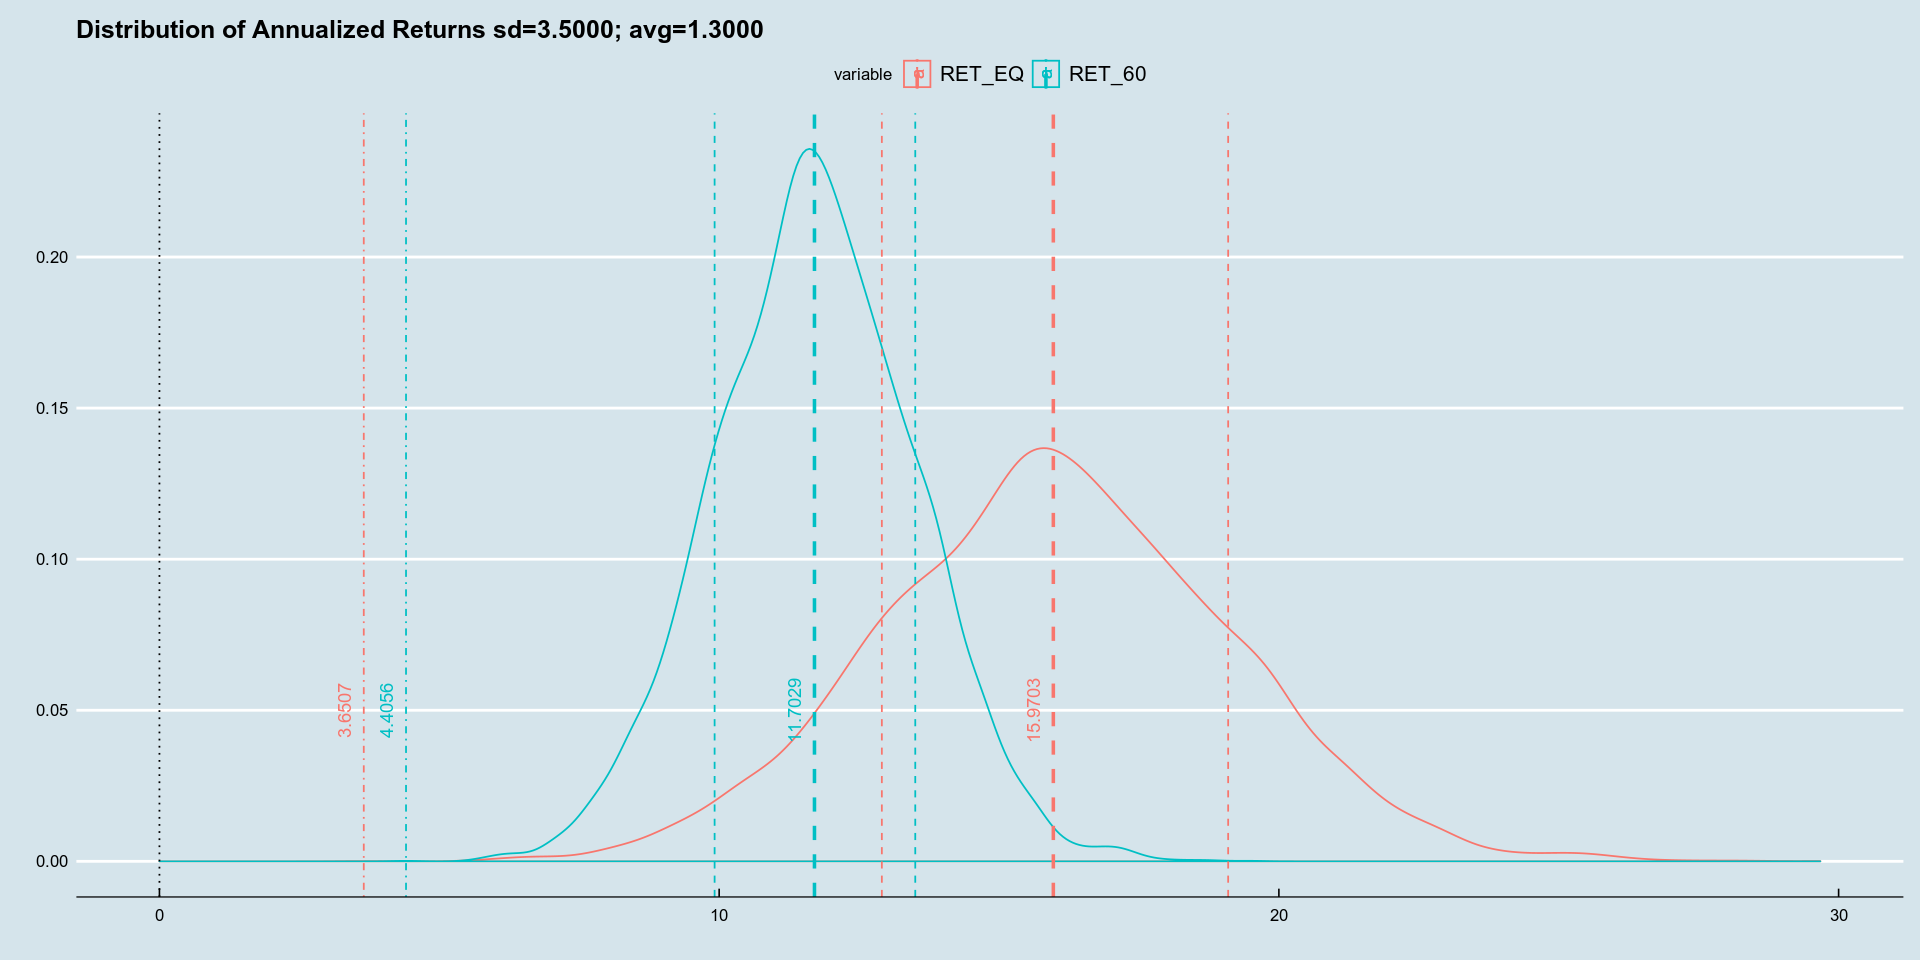

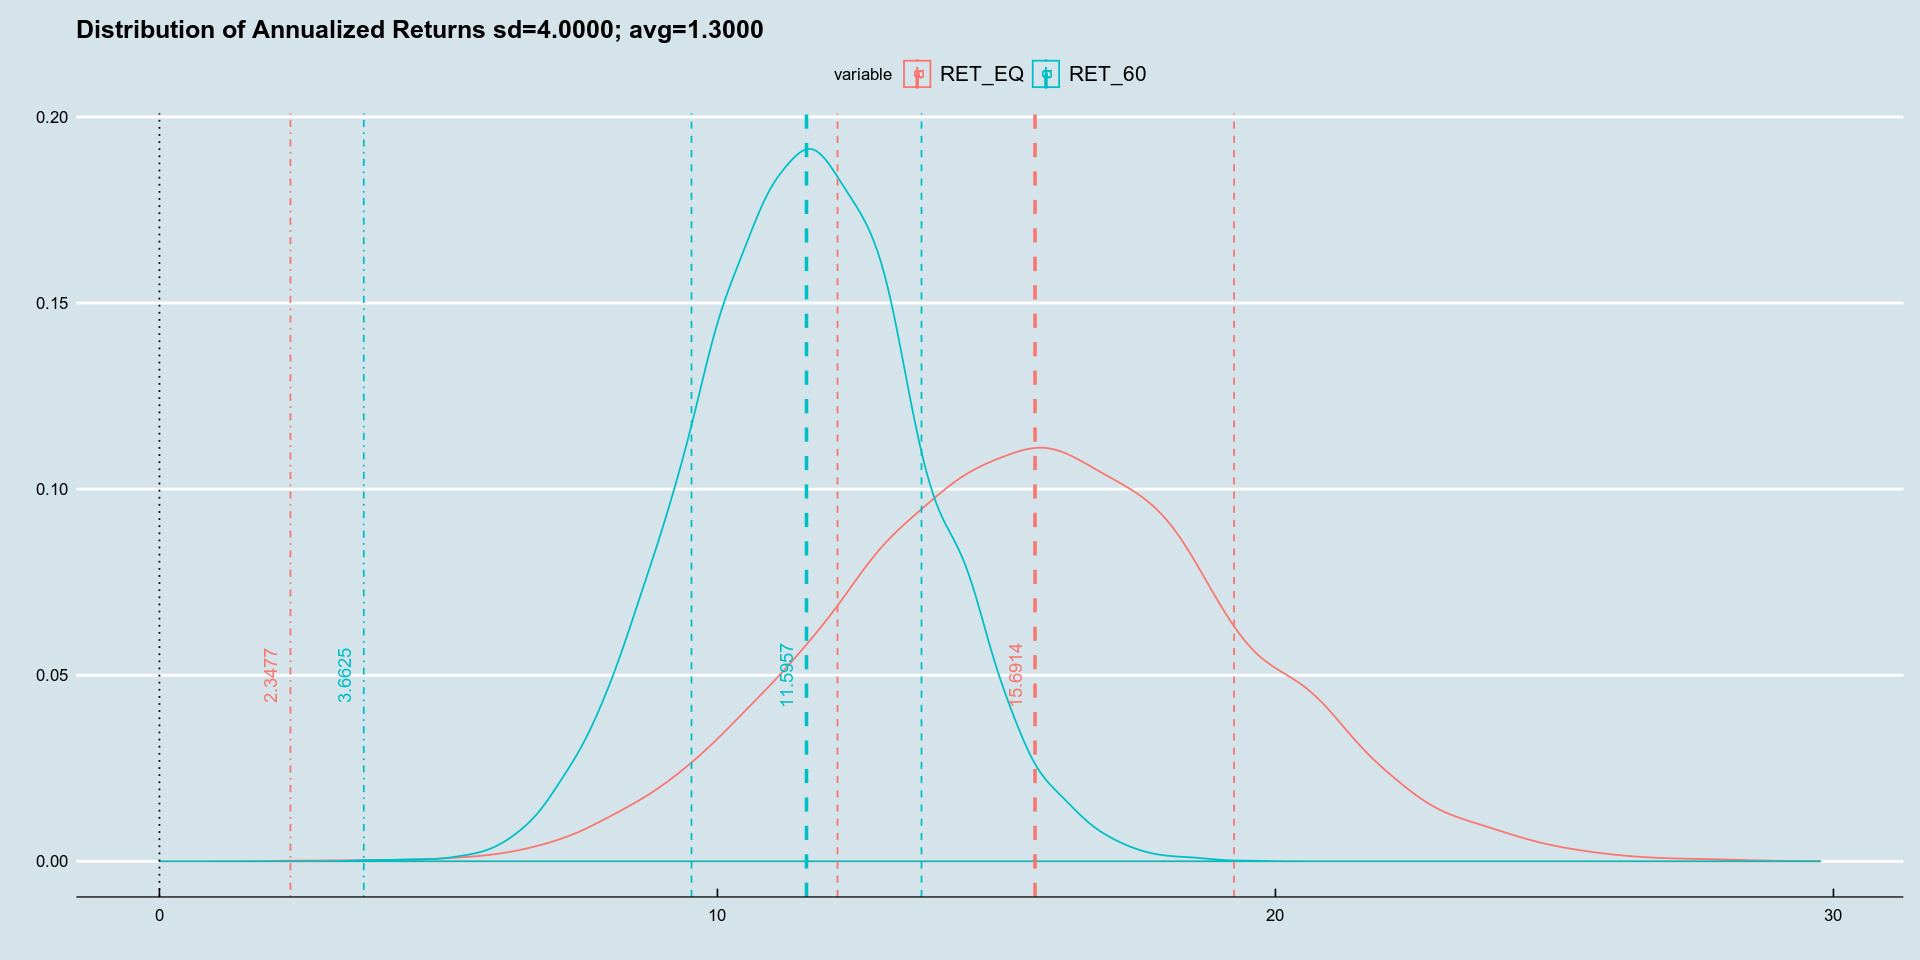

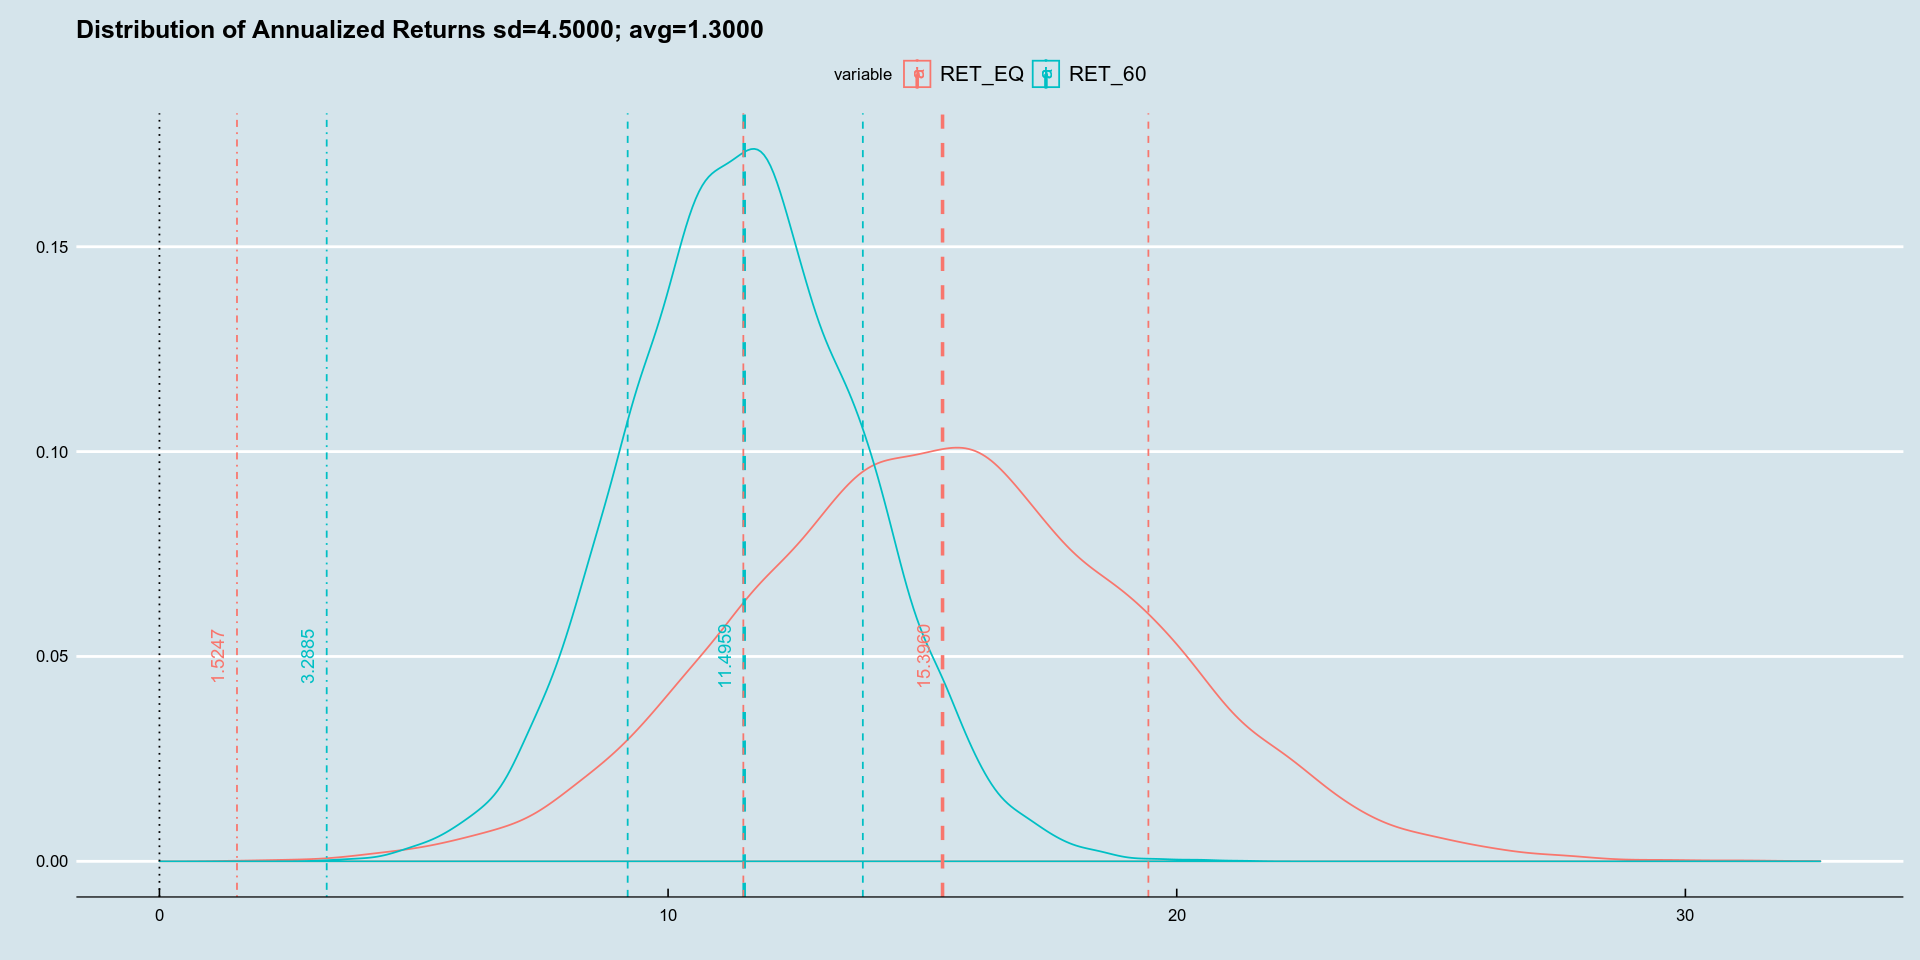

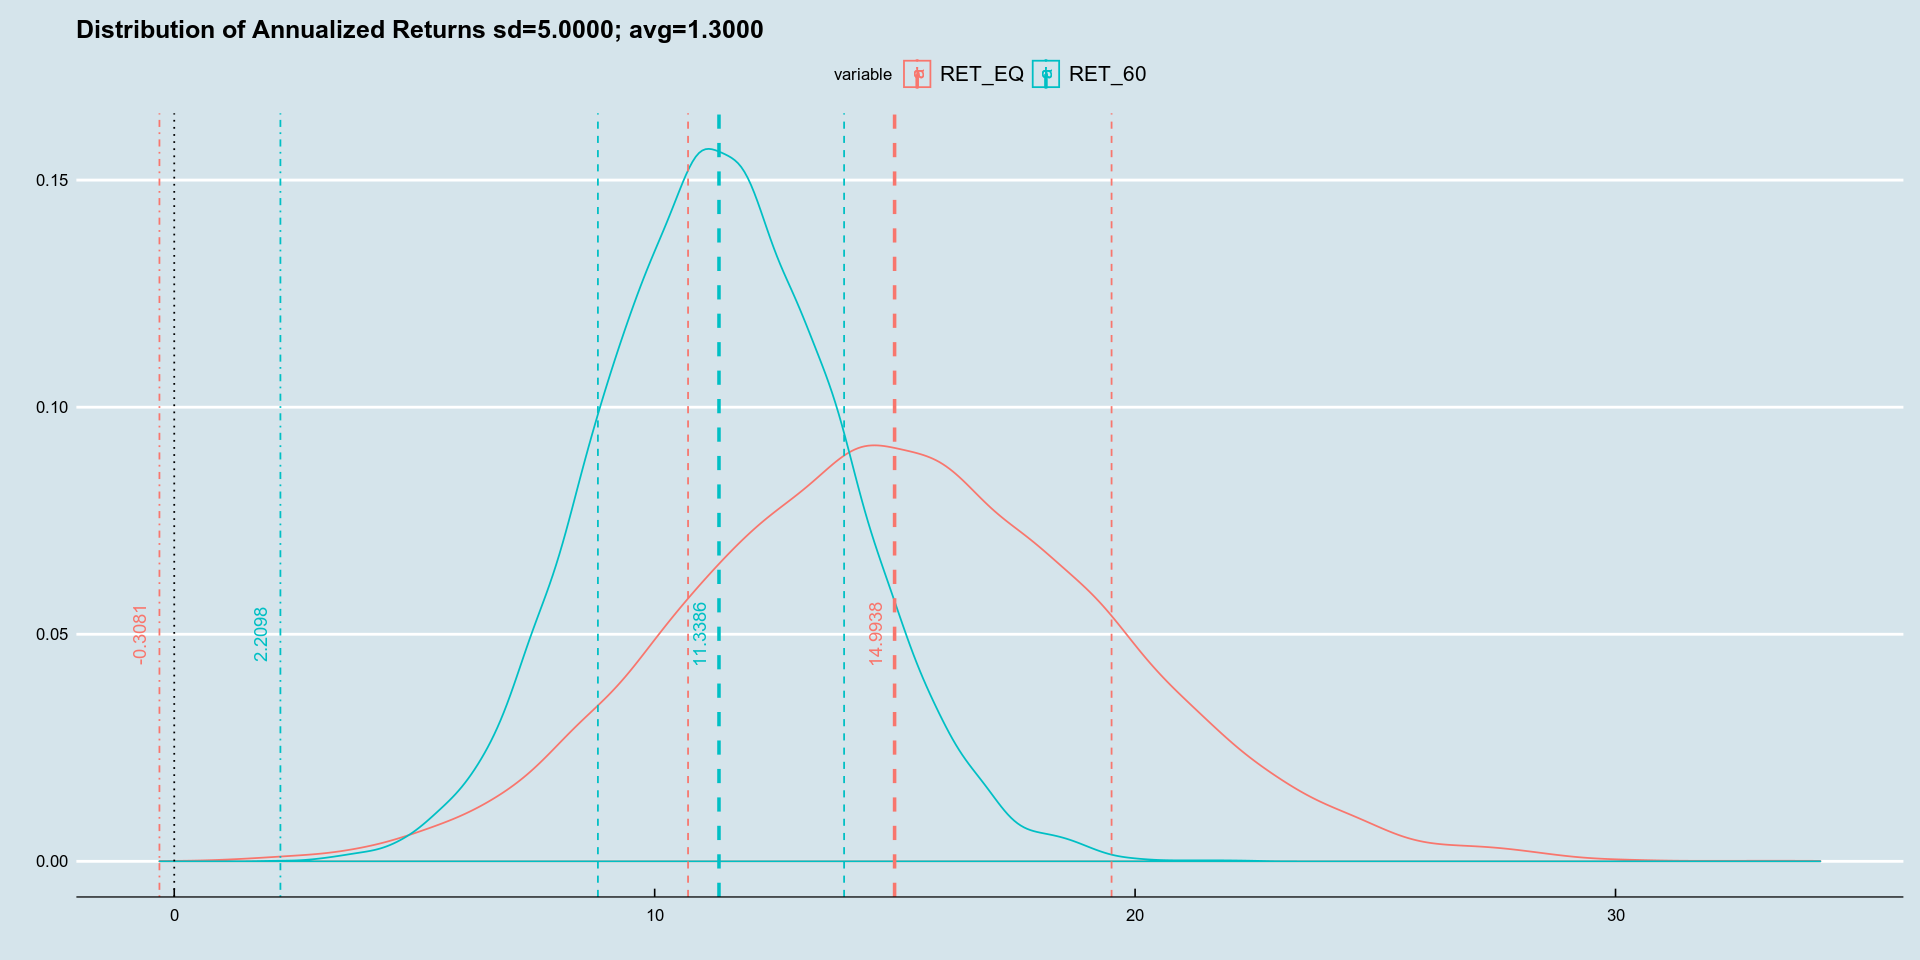

In [13]:
for(i in 1:length(sdVals)){
    plotDf <- simRets[simRets$I == i & simRets$J==jReal, c('RET_EQ', 'RET_60')]
    mainTitle <- sprintf("Distribution of Annualized Returns sd=%.4f; avg=%.4f", 100*sdVals[i], 100*avgVals[jReal])
    plotgg <- ggplot(melt(plotDf), aes(x=value, color=variable)) +
            theme_economist() +
            geom_density() +
            labs(x='', y='', fill='', line='', title=mainTitle) +
            geom_vline(aes(xintercept=0), linetype='dotted', color='black') +
            geom_vline(data = melt(summs[summs$I == i & summs$X == 'MEDIAN', c('X', 'RET_EQ', 'RET_60')], id='X'), 
                       aes(xintercept=value, color=variable), linetype="dashed", size=1) +
            geom_text(data = melt(summs[summs$I == i & summs$X == 'MEDIAN', c('X', 'RET_EQ', 'RET_60')], id='X'),
                      aes(x=value, label=sprintf("%.4f", value), y=0.05, colour=variable), angle=90, vjust = -1) +
            geom_vline(data = melt(summs[summs$I == i & (summs$X == 'SDP' | summs$X == 'SDM'), c('X', 'RET_EQ', 'RET_60')], id='X'), 
                       aes(xintercept=value, color=variable), linetype="dashed", size=0.5) +
            geom_vline(data = melt(summs[summs$I == i & summs$X == 'MIN', c('X', 'RET_EQ', 'RET_60')], id='X'), 
                       aes(xintercept=value, color=variable), linetype="dotdash", size=0.5) +
            geom_text(data = melt(summs[summs$I == i & summs$X == 'MIN', c('X', 'RET_EQ', 'RET_60')], id='X'),
                      aes(x=value, label=sprintf("%.4f", value), y=0.05, colour=variable), angle=90, vjust = -1)

    print(plotgg)
}

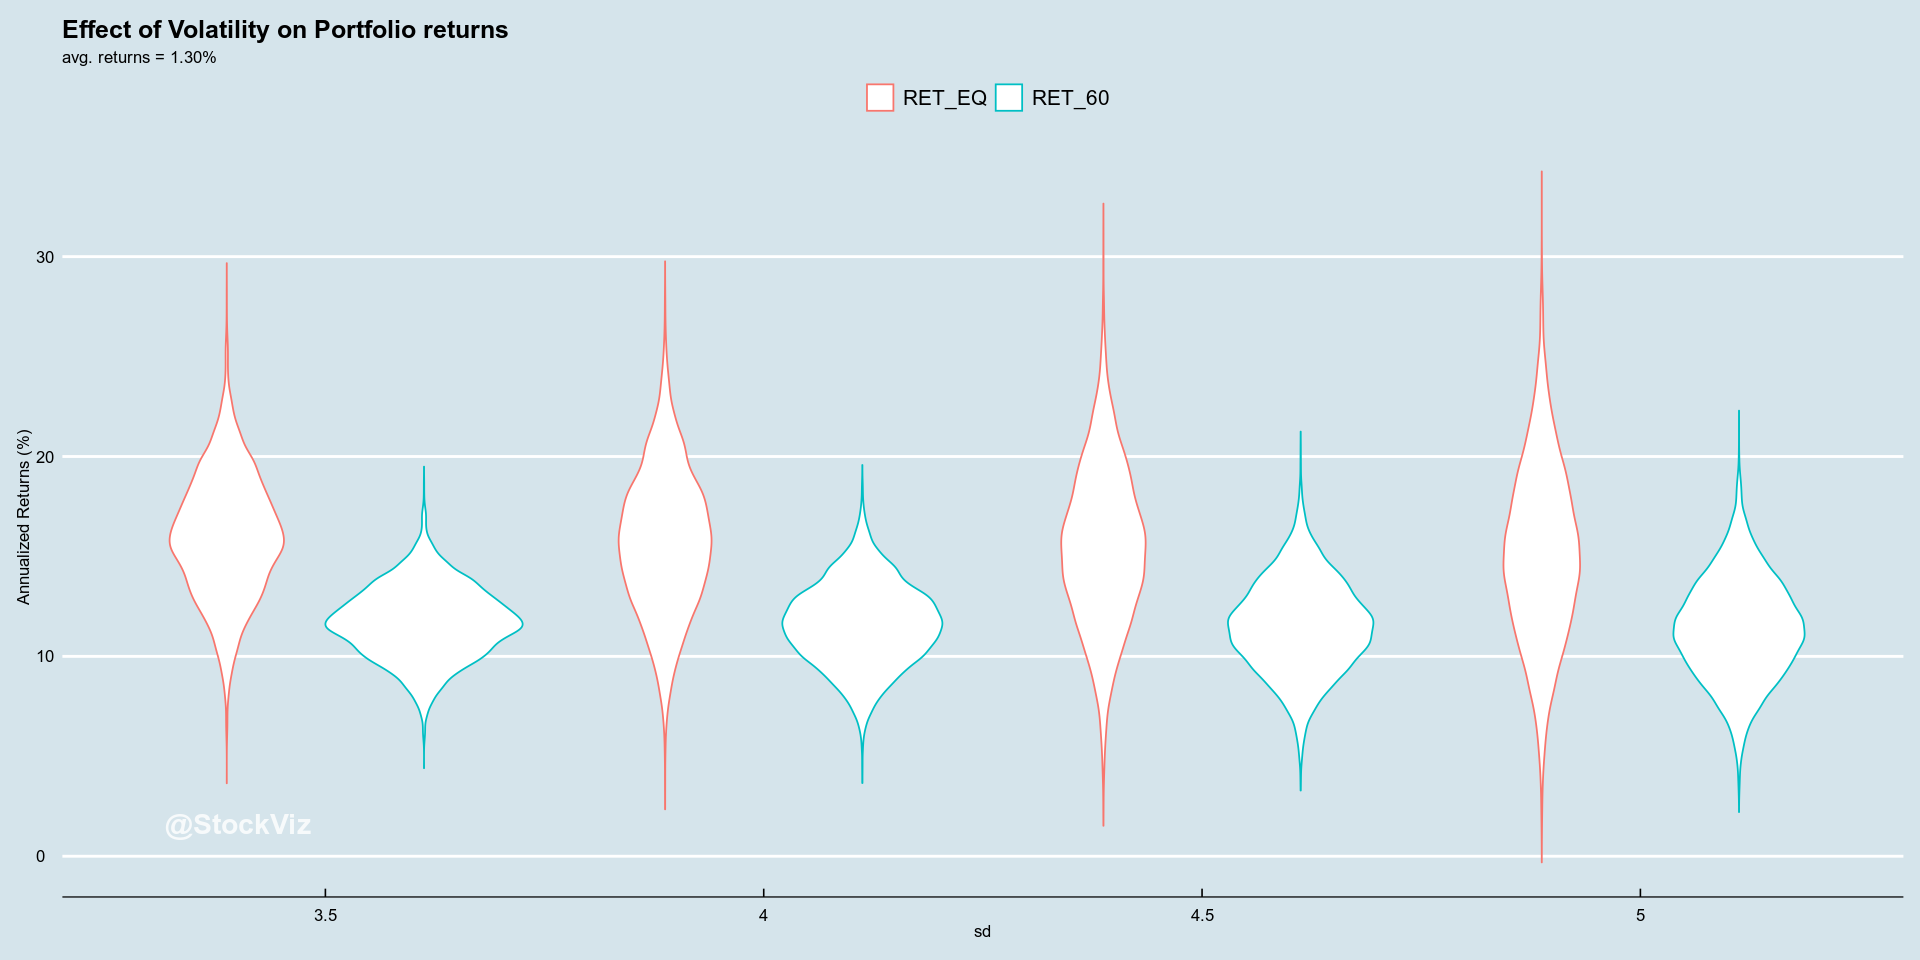

In [14]:
sliceDf <- simRets[simRets$J == jReal,]
sliceDf <- data.frame(X=100*sdVals[sliceDf$I], RET_EQ=sliceDf$RET_EQ, RET_60=sliceDf$RET_60)
sliceDf$X <- factor(sliceDf$X, levels=unique(sliceDf$X))
aggPlotDf <- melt(sliceDf, id='X')

ggplot(aggPlotDf, aes(x=X, y=value, color=variable)) + 
    theme_economist() +
    geom_violin() +
    labs(x='sd', y='Annualized Returns (%)', fill='', color='',
         title="Effect of Volatility on Portfolio returns",
         subtitle=sprintf("avg. returns = %.2f%%", 100*avgVals[jReal])) +
    annotate("text", x=1, y=0, 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

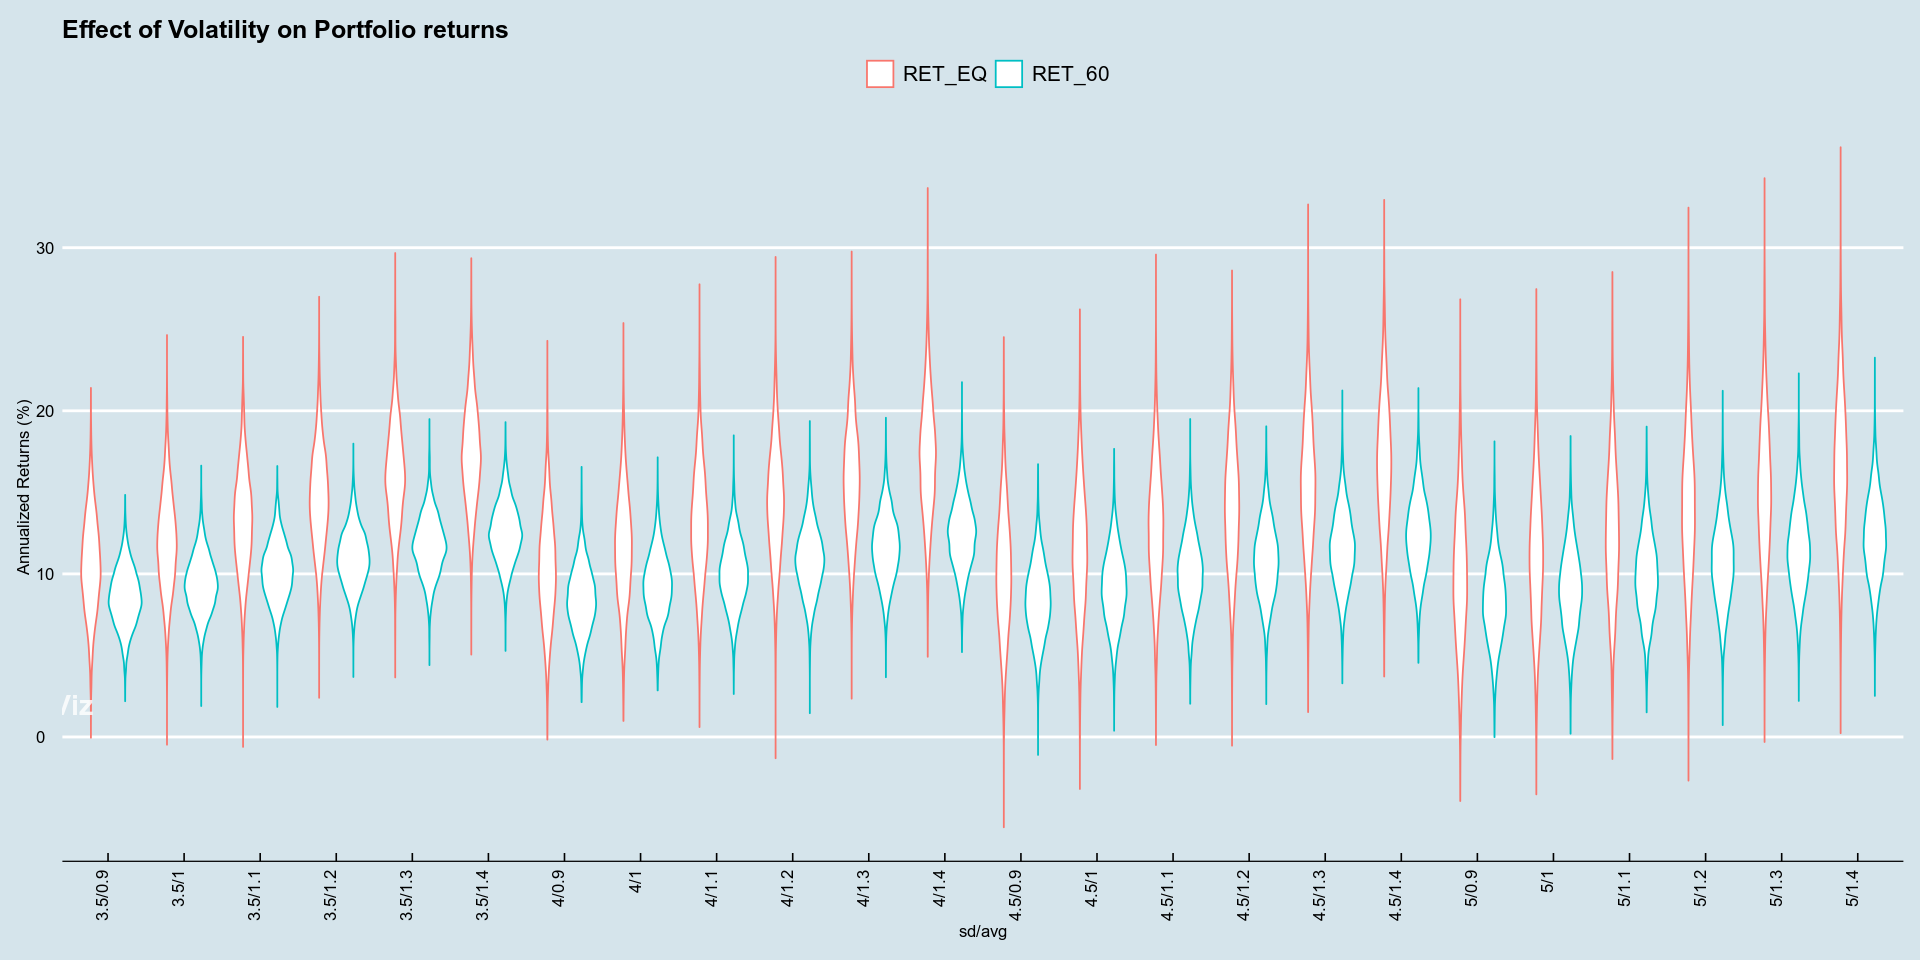

In [15]:
aggDf <- data.frame(X=paste0(100*sdVals[simRets$I], '/', 100*avgVals[simRets$J]), RET_EQ=simRets$RET_EQ, RET_60=simRets$RET_60)
aggDf$X <- factor(aggDf$X, levels=unique(aggDf$X))
aggPlotDf <- melt(aggDf, id='X')
ggplot(aggPlotDf, aes(x=X, y=value, color=variable)) + 
    theme_economist() +
    theme(axis.text.x=element_text(angle=90, hjust=1)) +
    geom_violin() +
    labs(x='sd/avg', y='Annualized Returns (%)', fill='', color='',
         title="Effect of Volatility on Portfolio returns") +
    annotate("text", x=1, y=0, 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

As volatility increases, the 60/40 has the effect of limiting downside. But, if volatility continues to remain low, ten even at lower levels of average returns, you are better off with an all equity portfolio.

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!